In [1]:
import datetime
import time
from datetime import timedelta
from pathlib import Path
from pprint import pprint

import mpu
import nest_asyncio
import pandas as pd
import rapidjson
from freqtrade.configuration import Configuration

from lazyft.downloader import download
from lazyft.command_parameters import HyperoptParameters
from lazyft.strategy import load_strategy
from loguru import logger

from sklearn.preprocessing import robust_scale
from stable_baselines3.common.monitor import Monitor

import wandb
from trading_environments.my_freqtrade_env import Actions, SagesFreqtradeEnv

nest_asyncio.apply()

### Config

In [2]:
STRATEGY = "SagesGym5"
CONFIG = "configs/config.json"
PAIR = "BTC/USDT"
TRAINING_RANGE = "20180101-20201231"
VALIDATION_RANGE = "20210101-20211231"
TEST_RANGE = "20220101-"
TIMEFRAME = "1h"
freqtrade_config = Configuration.from_files([CONFIG])
freqtrade_config["timeframe"] = TIMEFRAME
freqtrade_config["pairs"] = [PAIR]
WINDOW_SIZE = 20
REQUIRED_STARTUP_CANDLES = WINDOW_SIZE
STARTING_CAPITAL = 1000
STAKE_AMOUNT = 100
# endregion

# todo load last saved score and use it as a starting point to prevent overwriting
MODEL_NAME = ""

LOAD_PREPROCESSED_DATA = False  # useful if you have to calculate a lot of features
SAVE_PREPROCESSED_DATA = True

LEARNING_TIME_STEPS = 4000000
LOG_DIR = "./logs/"
# TENSORBOARD_LOG = "./tensorboard/"
MODEL_DIR = Path("./models/")
_preprocessed_data_file = Path(
    "preprocessed",
    f"preprocessed_data__{PAIR.replace('/', '_')}__{TRAINING_RANGE}__{WINDOW_SIZE}.pickle",
)
"""End of settings"""
INDICATOR_FILTER = ["date", "open", "close", "high", "low", "volume"]

# hmm_model = Path(MODEL_DIR, f'btc_hmm.pickle')
model_dict_path = MODEL_DIR / "models.json"
if not model_dict_path.exists():
    model_dict = {}
else:
    model_dict = rapidjson.loads(model_dict_path.read_text())
    

print('Model directory:', MODEL_DIR)
print('Model dict:', model_dict)
print('Preprocessed data file:', _preprocessed_data_file)

config = {
    "strategy": STRATEGY,
    "config": CONFIG,
    "pair": PAIR,
    "training_range": TRAINING_RANGE,
    "timeframe": TIMEFRAME,
    "window_size": WINDOW_SIZE,
    "required_startup_candles": REQUIRED_STARTUP_CANDLES,
    "learning_time_steps": LEARNING_TIME_STEPS,
    "log_dir": LOG_DIR,
    "model_dir": MODEL_DIR,
    "model_dict": model_dict,
    "preprocessed_data_file": _preprocessed_data_file,
    "load_preprocessed_data": LOAD_PREPROCESSED_DATA,
    # "policy_kwargs": POLICY_KWARGS,
    "starting_capital": STARTING_CAPITAL,
    "stake_amount": STAKE_AMOUNT,
}
print('Config:')
pprint(config)

Model directory: models
Model dict: {}
Preprocessed data file: preprocessed/preprocessed_data__BTC_USDT__20180101-20201231__20.pickle
Config:
{'config': 'configs/config.json',
 'learning_time_steps': 4000000,
 'load_preprocessed_data': False,
 'log_dir': './logs/',
 'model_dict': {},
 'model_dir': PosixPath('models'),
 'pair': 'BTC/USDT',
 'preprocessed_data_file': PosixPath('preprocessed/preprocessed_data__BTC_USDT__20180101-20201231__20.pickle'),
 'required_startup_candles': 20,
 'stake_amount': 100,
 'starting_capital': 1000,
 'strategy': 'SagesGym5',
 'timeframe': '1h',
 'training_range': '20180101-20201231',
 'window_size': 20}


### Preprocess

In [15]:
!freqtrade download-data --config configs/config.json --pairs BTC/USDT --timerange {TRAINING_RANGE} --timeframe {TIMEFRAME} --user-data-dir user_data

2023-10-11 02:02:04,664 - freqtrade - INFO - freqtrade 2022.12
2023-10-11 02:02:04,664 - freqtrade.configuration.load_config - INFO - Using config: configs/config.json ...
2023-10-11 02:02:04,665 - freqtrade.loggers - INFO - Verbosity set to 0
2023-10-11 02:02:04,665 - freqtrade.configuration.configuration - INFO - Parameter --timerange detected: 20180101-20201231 ...
2023-10-11 02:02:04,665 - freqtrade.configuration.configuration - INFO - Using user-data directory: user_data ...
2023-10-11 02:02:04,665 - freqtrade.configuration.directory_operations - INFO - Created data directory: None
2023-10-11 02:02:04,665 - freqtrade.configuration.configuration - INFO - Using data directory: user_data/data/binanceus ...
2023-10-11 02:02:04,665 - freqtrade.configuration.configuration - INFO - Using pairs ['BTC/USDT']
2023-10-11 02:02:04,666 - freqtrade.configuration.configuration - INFO - timeframes --timeframes: ['1h']
2023-10-11 02:02:04,666 - freqtrade.configuration.configuration - INFO - Filter

In [3]:
from freqtrade.data import history
from freqtrade.configuration import TimeRange
from lazyft.data_loader import load_pair_data

timerange = TimeRange.parse_timerange(TRAINING_RANGE)

ohlc_data = history.load_data(
    datadir=freqtrade_config["datadir"],
    pairs=[PAIR],
    timeframe=TIMEFRAME,
    timerange=timerange,
    startup_candles=REQUIRED_STARTUP_CANDLES + 1,
    fail_without_data=True,
    data_format=freqtrade_config.get("dataformat_ohlcv", "json"),
)
price_data = load_pair_data(PAIR,TIMEFRAME, timerange=TRAINING_RANGE, startup_candles=REQUIRED_STARTUP_CANDLES)
print('Loaded data:\n', price_data)

/Users/raphael/PycharmProjects/freqgym/venv/lib/python3.11/site-packages/freqtrade/data/history/jsondatahandler.py:78: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pairdata['date'] = to_datetime(pairdata['date'],
2023-10-11 03:47:49.651 | INFO     | lazyft.data_loader:load_pair_data:47 - Loaded 11153 rows for BTC/USDT @ timeframe 1h, data starts at 2019-09-23 08:00:00+00:00


Loaded data:
                            date  open  high   low  close  volume
0     2019-09-23 08:00:00+00:00 9.93K 9.93K 9.93K  9.93K   0.001
1     2019-09-23 09:00:00+00:00 9.93K 9.93K 9.93K  9.93K   0.000
2     2019-09-23 10:00:00+00:00 9.93K 9.93K 9.93K  9.93K   0.000
3     2019-09-23 11:00:00+00:00 9.93K 9.93K 9.93K  9.93K   0.000
4     2019-09-23 12:00:00+00:00 9.93K 9.93K 9.93K  9.93K   0.000
...                         ...   ...   ...   ...    ...     ...
11148 2020-12-30 20:00:00+00:00 28.8K   29K 28.6K  28.8K  11.538
11149 2020-12-30 21:00:00+00:00 28.8K   29K 28.6K  28.9K  16.847
11150 2020-12-30 22:00:00+00:00 28.9K 28.9K 28.6K  28.7K   4.966
11151 2020-12-30 23:00:00+00:00 28.7K 28.9K 28.6K  28.9K  11.346
11152 2020-12-31 00:00:00+00:00 28.9K 29.3K 28.9K  29.1K  29.346

[11153 rows x 6 columns]


In [4]:
from user_data.strategies import custom_indicators

price_data = custom_indicators.add_smi_signal(price_data)
price_data = custom_indicators.add_ema_signal(price_data)
price_data = custom_indicators.add_sar_signal(price_data)
price_data = custom_indicators.add_ha_signal(price_data)
price_data = custom_indicators.add_adx_di_signal(price_data)
# price_data = custom_indicators.add_donchian_trend_signal(price_data)

In [5]:
price_data[["ema_signal", "smi_signal", "sar_signal", "ha_signal", "adx_di_signal"]].value_counts()

ema_signal  smi_signal  sar_signal  ha_signal  adx_di_signal
0           0           0.000       0.000      0                4297
                                               1                 593
1           0           0.000       0.000      0                 246
0           1           0.000       0.000      0                  60
1           0           0.000       0.000      1                  15
                                                                ... 
0           0           0.000       0.021      0                   1
                                               0                   1
                                               1                   1
                                               0                   1
1           1           0.508       0.072      1                   1
Name: count, Length: 5947, dtype: int64

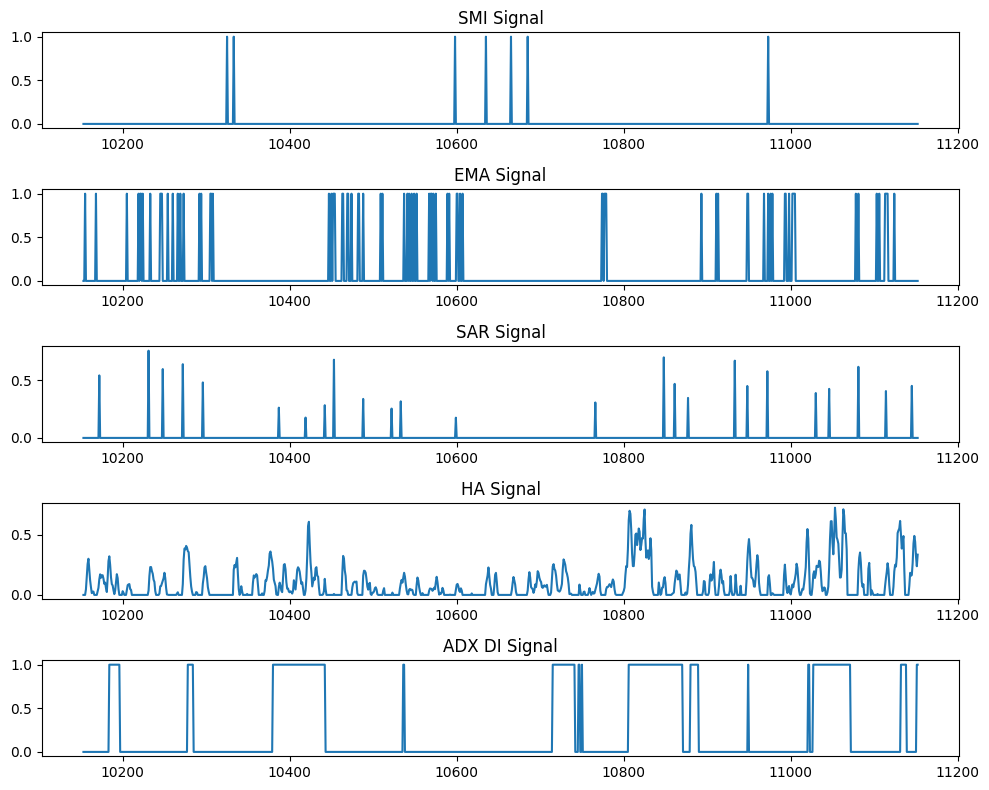

In [6]:
import matplotlib.pyplot as plt
import mplfinance as mpf


price_data = price_data.tail(1000)
# Convert 'date' column to datetime
# price_data['date'] = pd.to_datetime(price_data['date'])

# Set 'date' column as index
# price_data.set_index('date', inplace=True)

# Create subplots
fig, axs = plt.subplots(5, figsize=(10, 8))

# Plot OHLC data using a candlestick chart
# mpf.plot(price_data, type='candle', ax=axs[0])

# Plot SMI signal
price_data['smi_signal'].plot(ax=axs[0], title='SMI Signal')

# Plot EMA signal
price_data['ema_signal'].plot(ax=axs[1], title='EMA Signal')

# Plot SAR signal
price_data['sar_signal'].plot(ax=axs[2], title='SAR Signal')

# Plot HA signal
price_data['ha_signal'].plot(ax=axs[3], title='HA Signal')

# Plot Donchian Trend signal
price_data['adx_di_signal'].plot(ax=axs[4], title='ADX DI Signal')


# Show the plot
plt.tight_layout()
plt.show()


In [4]:
from trading_environments.data import MultiTimeFramePairData
import sys
strategy = load_strategy(STRATEGY, freqtrade_config)
parameters = HyperoptParameters(
    timerange=TRAINING_RANGE,
    interval=TIMEFRAME,
    pairs=[PAIR],
    config_path=CONFIG,
)
if LOAD_PREPROCESSED_DATA:
    # logger.info("Loading preprocessed data from file")
    # assert _preprocessed_data_file.exists(), "Unable to load preprocessed data!"
    # populated_data = mpu.io.read(str(_preprocessed_data_file))
    # assert (
    #     PAIR in populated_data
    # ), f"Loaded preprocessed data does not contain pair {PAIR}!"
    # populated_pair_data = populated_data[PAIR]
    pass
else:
    # logger.info("Preprocessing data...")
    # populated_data = strategy.advise_all_indicators(ohlc_data)
    # populated_pair_data = populated_data[PAIR]
    # populated_pair_data.reset_index(drop=True, inplace=True)
    # logger.info("Dropping rows with NaN values")
    # populated_pair_data.dropna(inplace=True)
    # logger.info(f"Temp new index begins at: {populated_pair_data.index[0]}")
    # populated_pair_data.reset_index(drop=True, inplace=True)

    # if SAVE_PREPROCESSED_DATA:
    #     logger.info("Saving preprocessed data to file")
    #     mpu.io.write(str(_preprocessed_data_file), {PAIR: populated_pair_data})
    pass
m = MultiTimeFramePairData("BTC/USDT", ["1h"], TRAINING_RANGE)


price_data = m.data[m.highest_timeframe].data

print('Loaded data:\n', price_data)

def add_return(df: pd.DataFrame, x: str, y: str):
    df[y] = df[x].pct_change()
    df[y] = robust_scale(df[y])
    return df


m.do_func_on_data(add_return, "close", "return")
data = m.create_combined_data("return", window=WINDOW_SIZE)
# price_data = ohlc_data[PAIR]
# price_data["return"] = price_data["close"].pct_change(1)
# price_data['volume_return'] = price_data['volume'].pct_change(1)
# price_data = price_data.fillna(0)
# remove price data with 0 volume
# price_data = price_data[price_data["volume"] > 0]
# for c in INDICATOR_FILTER:
#     # remove every column that contains a substring of c
#     indicators = indicators.drop(columns=[col for col in indicators.columns if c in col])
# indicators.fillna(0, inplace=True)
# input_data = price_data[["return"]]
# input_data['return'] = input_data['close'].pct_change()
# input_data = input_data.dropna()

# input_data = pd.DataFrame(
#     robust_scale(input_data.values),
#     columns=input_data.columns,
#     index=input_data.index,
# )

# input_data["date"] = price_data["date"]

config.update(
    {
        "input_shape": list(data.values())[0].shape,
        # "input_columns": input_data.columns.to_list(),
    }
)

print("Price data:\n", price_data.describe())
print("Price data shape:", price_data.shape)
print(
    "Price data memory usage:",
    round(price_data.memory_usage(index=True).sum() / 1024**2, 2),
    "MB",
)
print()
# print("Input data:\n", list(data.values()))
print("Input data length:", len(data))
print("Input data shape:", list(data.values())[0].shape)
print(
    "Input data memory usage (MB):",
    round(sys.getsizeof(data) / 1024**2, 2),
    "MB",
)


2022-05-04 12:53:30.053 | INFO     | lazyft.downloader:download_missing_historical_data:302 - Checking if download is needed for BTC/USDT @ 5m interval(s)
2022-05-04 12:53:30.054 | INFO     | lazyft.downloader:download_missing_historical_data:339 - Data is up to date
2022-05-04 12:53:31.058 | INFO     | lazyft.data_loader:load_pair_data:51 - Loaded 315361 rows for BTC/USDT @ timeframe 5m, data starts at 2018-01-01 00:00:00+00:00
2022-05-04 12:53:31.059 | INFO     | lazyft.downloader:download_missing_historical_data:302 - Checking if download is needed for BTC/USDT @ 15m interval(s)
2022-05-04 12:53:31.060 | INFO     | lazyft.downloader:download_missing_historical_data:339 - Data is up to date
2022-05-04 12:53:31.367 | INFO     | lazyft.data_loader:load_pair_data:51 - Loaded 105121 rows for BTC/USDT @ timeframe 15m, data starts at 2018-01-01 00:00:00+00:00
2022-05-04 12:53:31.369 | INFO     | lazyft.downloader:download_missing_historical_data:302 - Checking if download is needed for BTC

Loaded data:
                            date  open  high   low  close  volume
0     2018-01-01 00:00:00+00:00 13.7K 13.7K 13.4K  13.5K 443.356
1     2018-01-01 01:00:00+00:00 13.5K 13.6K 13.2K  13.2K 383.697
2     2018-01-01 02:00:00+00:00 13.2K 13.4K 13.2K  13.3K 429.065
3     2018-01-01 03:00:00+00:00 13.3K 13.6K 13.3K  13.4K 420.087
4     2018-01-01 04:00:00+00:00 13.4K 13.6K 13.3K  13.6K 340.807
...                         ...   ...   ...   ...    ...     ...
26276 2020-12-30 20:00:00+00:00 28.8K   29K 28.6K  28.8K   4.27K
26277 2020-12-30 21:00:00+00:00 28.8K   29K 28.5K  28.9K   3.55K
26278 2020-12-30 22:00:00+00:00 28.9K 28.9K 28.6K  28.7K   1.92K
26279 2020-12-30 23:00:00+00:00 28.7K 28.9K 28.6K  28.9K   2.18K
26280 2020-12-31 00:00:00+00:00 28.9K 29.3K 28.9K  29.1K   5.52K

[26281 rows x 6 columns]


2022-05-04 12:54:52.453 | INFO     | trading_environments.data:rolling_generator:104 - Last slice is 19, not 20. Yielding tail of n=20


Price data:
        open  high   low  close  volume  return
count 26.3K 26.3K 26.3K  26.3K   26.3K   26.3K
mean  8.64K 8.68K 8.59K  8.64K   2.07K  -0.005
std   3.58K  3.6K 3.55K  3.58K   2.06K   1.631
min   3.17K 3.18K 3.16K  3.17K   0.000 -34.720
25%   6.54K 6.56K 6.52K  6.54K 962.829  -0.502
50%   8.29K 8.34K 8.24K  8.29K   1.49K   0.000
75%   10.1K 10.2K 10.1K  10.1K   2.41K   0.498
max   28.9K 29.3K 28.9K  29.1K   47.3K  33.109
Price data shape: (26281, 7)
Price data memory usage: 1.4 MB

Input data length: 26242
Input data shape: (20, 4)
Input data memory usage (MB): 2.55 MB


### Env

In [5]:
selected_data = price_data[["date", "adx_di_signal", "ha_signal", "sar_signal", "smi_signal", "ema_signal"]]

selected_data_dict = {row['date']: row[1:].values for _, row in selected_data.iterrows()}


In [6]:

from trading_environments.my_freqtrade_env2 import Actions, SagesFreqtradeEnv2
from trading_environments.my_freqtrade_env3 import Actions, SagesFreqtradeEnv3
from trading_environments.my_freqtrade_env4 import Actions, SagesFreqtradeEnv4
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.utils import set_random_seed
env = SagesFreqtradeEnv4(
    data=selected_data_dict,
    prices=price_data[["date", "open", "close", "high", "low", "volume"]],
    window_size=WINDOW_SIZE,  # how many past candles should it use as features
    pair=PAIR,
    stake_amount=STAKE_AMOUNT,
    starting_balance=STARTING_CAPITAL,
    punish_holding_amount=-2,
)
check_env(env)
trading_env = Monitor(env, LOG_DIR)
set_random_seed(1111, using_cuda=True)
config['action_shape'] = len(Actions)
config['punish_holding_amount'] = env.punish_holding_amount


/Users/raphael/PycharmProjects/freqgym/venv/lib/python3.11/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment MyFreqtradeEnv-v3 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
2023-10-11 03:48:02.578 | INFO     | trading_environments.my_freqtrade_env4:__init__:127 - Observation space: Box(0.0, 1.0, (5,), float32)
2023-10-11 03:48:02.578 | INFO     | trading_environments.my_freqtrade_env4:__init__:137 - Prices columns: ['date', 'open', 'close', 'high', 'low', 'volume'], shape: (11153, 6)


TypeError: The reset() method must accept a `seed` parameter

In [6]:
env._get_observation()

array([[ 2.56959435e+00, -5.85788196e-01,  4.74779691e-01,
         4.06305643e+00],
       [-4.18975980e-01,  1.58682650e-01, -6.43056138e-01,
         3.07253255e+00],
       [ 3.22001877e+00,  9.05488330e-01, -9.32164109e-01,
         1.75491432e+00],
       [-9.25284582e-01,  9.59170887e-01, -1.24781633e-01,
        -2.87824969e+00],
       [-2.12019181e+00,  3.58511777e-03,  5.72521066e-01,
         2.27793534e+00],
       [-6.14703330e+00,  5.85964046e-01,  8.59442801e-01,
         1.91944562e+00],
       [-8.62991004e-01, -7.46159079e-01, -5.34865435e-03,
         5.83477434e-01],
       [ 3.60118996e+00,  6.74180699e-01, -2.64498676e+00,
        -1.00645937e+00],
       [-3.64016440e+00, -1.31340098e+00,  8.02891008e-01,
        -2.16985621e-01],
       [ 5.32377208e+00,  2.40924807e-01, -4.19877971e-01,
        -3.40271655e+00],
       [-8.49946960e-01,  1.23603335e+00,  1.74863748e+00,
        -1.23537257e-01],
       [ 3.12199694e+00,  3.81976902e-02,  3.28549398e+00,
      

In [7]:
from pprint import pprint
# print('space:', env.observation_space)
env.observation_space.sample()

array([[ 1.5537229 , -0.15493975, -0.76748437,  0.62240978],
       [ 1.70844037, -0.19616313,  0.87127057,  0.58447959],
       [-0.02748547, -0.54476651,  0.12766414, -0.54722132],
       [-1.2015955 , -1.10933422, -0.43089147, -0.58296544],
       [-0.97739853, -1.59169037,  0.06911166, -0.51772149],
       [-0.08076266,  0.19974753, -0.35850264,  1.49374754],
       [-0.31399558, -0.57712608,  0.21876023,  1.04346274],
       [-0.09467324, -0.15371646,  0.19230476, -0.91773479],
       [-2.21489437, -0.68299387, -0.5376796 ,  0.58020488],
       [-0.36100386, -1.09943399,  1.25787313,  0.33316256],
       [ 0.7627274 , -0.5905462 , -0.22939408, -0.8489011 ],
       [ 0.43431793,  0.1607605 , -1.13981759,  0.20517348],
       [-0.69449624,  0.71225198, -0.67777628,  0.0369299 ],
       [-1.12951983,  0.52850326, -0.49056839,  0.24931994],
       [-0.19796866,  0.40951777,  0.70556501, -0.29172627],
       [-2.30306907, -0.49419885,  1.02528629, -1.00170813],
       [-1.75258368,  0.

### Model

In [8]:
from pathlib import Path
from tb_callbacks import SaveOnStepCallback
from stable_baselines3 import DQN
from sb3_contrib.ppo_recurrent import RecurrentPPO
from sb3_contrib.qrdqn import QRDQN


# POLICY_KWARGS = dict(net_arch=[128, 128])

if MODEL_NAME:
        # load existing model
        model = RecurrentPPO.load(
            MODEL_DIR / MODEL_NAME.strip(".zip"),
            # tensorboard_log=TENSORBOARD_LOG,
        )
        logger.success(f"Loaded model from {MODEL_DIR / MODEL_NAME}")
        model.set_env(trading_env)
else:
    # policy = RecurrentActorCriticPolicy
    model = RecurrentPPO(
        # See https://stable-baselines3.readthedocs.io/en/master/guide/algos.html for other algos with discrete action space
        # "MultiInputLstmPolicy",
        "MlpLstmPolicy",
        # "MlpPolicy",
        trading_env,
        verbose=0,
        device="cuda",
        # tensorboard_log=TENSORBOARD_LOG,
        n_steps=len(data) - WINDOW_SIZE,
        # gradient_steps=-1,
        gamma=0.9,
        learning_rate=0.0001,
        # ent_coef=0.0001123894292050861,
        # gae_lambda=0.8789545362092943,
        # reuse=True
        # policy_kwargs=POLICY_KWARGS,
    )
start_date = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
base_name = f"{STRATEGY}_{trading_env.env.__class__.__name__}_{model.__class__.__name__}_{start_date}"
tb_callback = SaveOnStepCallback(
    check_freq=len(data)*5,
    save_name=f"best_model_{base_name}",
    save_dir=str(MODEL_DIR),
    log_dir=LOG_DIR,
    verbose=1,
)
config['model_type'] = model.__class__.__name__
config['save_name'] = base_name
env.set_log_dir(Path('trade_logs', start_date))
print(base_name)

2022-05-04 12:54:53.950 | INFO     | trading_environments.my_freqtrade_env4:set_log_dir:537 - Log directory set to trade_logs/20220504_125453


SagesGym5_SagesFreqtradeEnv4_RecurrentPPO_20220504_125453


In [9]:
for m in model.policy.modules():
    print(m)

RecurrentActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential()
    (policy_net): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=3, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
  (lstm_actor): LSTM(80, 256)
  (critic): Linear(in_features=80, out_features=256, bias=True)
)
FlattenExtractor(
  (flatten): Flatten(start_dim=1, end_dim=-1)
)
Flatten(start_dim=1, end_dim=-1)
MlpExtractor(
  (shared_net): Sequential()
  (policy_net): Sequential(
    (0): Linear(in_f

### Train

In [10]:
run = wandb.init(project="freqgym", entity="rtnanje", config=config)

wandb: Currently logged in as: rtnanje. Use `wandb login --relogin` to force relogin


In [11]:
from wandb.integration.sb3 import WandbCallback

logger.info("Learning started.")
callback = WandbCallback(
    model_save_path=f"models/best_model_{run.id}",
    verbose=2,
    model_save_freq=len(data) * 5,
)

# wandb.watch(model)
model.learn(total_timesteps=LEARNING_TIME_STEPS, callback=callback)


2022-05-04 12:54:57.094 | INFO     | __main__:<cell line: 3>:3 - Learning started.
2022-05-04 12:56:17.201 | INFO     | trading_environments.my_freqtrade_env4:step:455 - Out of capital. Trades made: 928
2022-05-04 12:57:21.702 | INFO     | trading_environments.my_freqtrade_env4:step:455 - Out of capital. Trades made: 852
2022-05-04 12:58:22.010 | INFO     | trading_environments.my_freqtrade_env4:step:455 - Out of capital. Trades made: 823
2022-05-04 12:59:26.061 | INFO     | trading_environments.my_freqtrade_env4:step:455 - Out of capital. Trades made: 855
2022-05-04 13:00:30.311 | INFO     | trading_environments.my_freqtrade_env4:step:455 - Out of capital. Trades made: 856
2022-05-04 13:01:54.451 | INFO     | trading_environments.my_freqtrade_env4:step:455 - Out of capital. Trades made: 935
2022-05-04 13:02:46.002 | INFO     | trading_environments.my_freqtrade_env4:step:455 - Out of capital. Trades made: 830
2022-05-04 13:03:55.232 | INFO     | trading_environments.my_freqtrade_env4:s

KeyboardInterrupt: 

wandb: Network error (ReadTimeout), entering retry loop.


In [ ]:
model.save(MODEL_DIR / f"final_model_{base_name}")
print("Model saved to:", MODEL_DIR / f"final_model_{base_name}")

In [ ]:
env.trades_as_df

In [ ]:
len(env.buy_observation_map)
print(env.buy_observation_map[(100,1)])
print(env.sell_observation_map[(100,2)])

### Test

In [ ]:
from lazyft.command_parameters import BacktestParameters

params = BacktestParameters(
    config_path="user_data/config.json",
    timerange=TRAINING_RANGE,
    interval=TIMEFRAME,
    # days=365,
    stake_amount=STAKE_AMOUNT,
    starting_balance=STARTING_CAPITAL,
    max_open_trades=1,
    pairs=[
        'BTC/USDT',
        # 'ETH/USDT',
    ],
    download_data=True,
    custom_settings={
        'model_path': str((MODEL_DIR / f"final_model_SagesGym5_SagesFreqtradeEnv_RecurrentPPO_20220430_210952").absolute().stem),
    }
)

runner = params.run('SagesGym5', load_from_hash=False)



In [ ]:
report = runner.save()
print(f'Sortino: {report.sortino_loss}', f'Sharpe: {report.sharp_loss}', sep='\n')

In [ ]:
!freqtrade backtesting -c /home/raphael/PycharmProjects/freqgym/user_data/config.json --user-data-dir /home/raphael/PycharmProjects/freqgym/user_data --strategy-path /home/raphael/PycharmProjects/freqgym/user_data/strategies --timerange {TRAINING_RANGE} --pairs BTC/USDT --starting-balance 1000 --stake-amount 100 --max-open-trades 1 --timeframe 1d -s SagesGym5 --cache none

In [ ]:
report.trades